# Thin Region Dataset - Transformations

# Auxiliar Functions 

In [1]:
def visualize_patchs(inputs, gts, gts_edge, meta):
    """
    Visualize input, ground truth and ground truth edge.
    
    Parameters
    ----------
    inputs_lr : torch.Tensor
        Input images.
    gts_lr : torch.Tensor
        Ground truth masks.
    gts_edge : torch.Tensor
        Patches of edges from Ground real masks.
    meta : dict
        Metadata.
    """
    inputs = inputs.squeeze(dim=0) # remove batch dimension
    inputs = inputs[:, :3] # catch only RGB channels
    gts = gts.squeeze()
    gts_edge = gts_edge.squeeze()
    
    fig, ax = plt.subplots(3, 5, figsize=(15, 8))

    for i in range(inputs.shape[0]):
        img = inputs[i].cpu().long() # send to cpu and convert to long
        img = img.permute(1, 2, 0).numpy() # permute and convert to numpy    
        mask = gts[i].cpu().long().numpy() # send to cpu, convert to long and numpy
        mask_edge = gts_edge[i].cpu().long().numpy() # send to cpu, convert to long and numpy  


        ax[0][i].imshow(img, cmap='gray')
        ax[0][i].axis('off')
        ax[0][i].set_title(f" {meta['image'][0]} \nImg  patch {i+1}")

        ax[1][i].imshow(mask, cmap='gray')
        ax[1][i].axis('off')
        ax[1][i].set_title(f'Mask patch {i+1}')          
        
        ax[2][i].imshow(mask_edge, cmap='gray')
        ax[2][i].axis('off')
        ax[2][i].set_title(f'Edge - Mask patch {i+1}')  
        fig.tight_layout()

In [2]:
def visualize_image_mask(inputs_lr, gts_lr, gt_edge_lr, meta):
    """
    Visualizes the input images and corresponding ground truth masks.
    
    Parameters
    ----------
    inputs_lr : torch.Tensor
        Input images.
    gts_lr : torch.Tensor
        Ground truth masks.
    gt_edge_lr : torch.Tensor
        Ground truth edge masks in Low Resolution.
    meta : dict
        Metadata.

    Returns
    -------
    None.
    """ 

    inputs_lr = inputs_lr.squeeze(dim=0)
    inputs_lr = inputs_lr[:3] # catch only RGB channels

    gts_lr = gts_lr.squeeze()
    gt_edge_lr = gt_edge_lr.squeeze()

    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    img = inputs_lr.cpu().long() # send to cpu and convert to long
    img = img.permute(1, 2, 0).numpy() # permute and convert to numpy
    mask = gts_lr.cpu().long().numpy() # send to cpu, convert to long and numpy
    mask_edge = gt_edge_lr.cpu().long().numpy() # send to cpu, convert to long and numpy

    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f"{meta['image'][0]} \nImg  patch")

    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title(f"{meta['image'][0]} \nMask Thin Region Only")
    
    ax[2].imshow(mask_edge, cmap='gray')
    ax[2].axis('off')
    ax[2].set_title(f"{meta['image'][0]} \nEdge - Mask Thin Region Only")
    fig.tight_layout()



In [3]:
def extract_transformed_sample(trainloader,  device='cuda'):
    """
    Extracts a transformed sample from the trainloader.
    
    Parameters
    ----------
    trainloader : torch.utils.data.DataLoader
        DataLoader for training dataset.
    
    Returns
    -------
    sample : dict
        Sample from the trainloader.
    inputs : torch.Tensor
        Patches of input image.
    inputs_lr : torch.Tensor    
        Low resolution input image.
    gts : torch.Tensor
        Ground truth masks.
    gts_lr : torch.Tensor
        Low resolution ground truth masks.
    gt_edge_lr : torch.Tensor
       Edges from Ground real masks in low resolution.
    gts_edge : torch.Tensor
       Patches of edges from Ground real masks.
    """

    sample = next(iter(trainloader))

    # Read inputs and ground truths
    inputs      = sample['concat'].to(device)
    inputs_lr   = sample['concat_lr'].to(device)
    gts         = sample['crop_gt'].to(device)
    gts_lr      = sample['lr_gt'].to(device)
    gts_edge    = sample['crop_gt_edge'].to(device)
    gt_edge_lr  = sample['lr_gt_edge'].to(device)
    meta        = sample['meta']

    # Threshold
    gts = torch.ge(gts, 0.5).float() 
    gts_lr = torch.ge(gts_lr, 0.5).float()
    gts_edge = torch.ge(gts_edge, 0.5).float()
    gt_edge_lr  = torch.ge(gt_edge_lr, 0.5).float()

    # Rearrange the inputs
    inputs = inputs.view(5, 4, 512, 512)
    inputs_lr = inputs_lr.view(1, 4, 512, 512)
    gts = gts.view(5, 1, 512, 512)
    gts_edge = gts_edge.view(5, 1, 512, 512)
    gts_lr = gts_lr.view(1, 1, 512, 512)
    gt_edge_lr = gt_edge_lr.view(1, 1, 512, 512)
    
    return sample, inputs, inputs_lr, gts, gts_lr, gt_edge_lr, gts_edge, meta




# Imports and setup

In [4]:
""" Train TOS-Net. """
import os
os.environ['OMP_NUM_THREADS'] = "8"
from collections import OrderedDict
from datetime import datetime
import glob
import numpy as np
import argparse
import random
import json

# PyTorch includes
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision

from torch.utils.data import DataLoader
from torch.nn.functional import interpolate, sigmoid
import torch.backends.cudnn as cudnn

# Custom includes
import dataloaders.thinobject5k as thinobject5k
import dataloaders.custom_transforms as tr
import dataloaders.helpers as helpers

import matplotlib.pyplot as plt


In [5]:
# Default settings
MODEL_NAME = 'TOSNetFineTuning'
RANDOM_SEED = 1234
# Network-specific arguments
NUM_INPUTS = 4                  # input channels
NUM_CLASSES = 1                 # number of classes
BACKBONE = 'resnet50'           # backbone architecture
LR_SIZE = 512                   # size of context stream
# Training-specific arguments
NUM_THIN_SAMPLES = 4            # number of samples consisting of thin parts
NUM_NON_THIN_SAMPLES = 1        # number of samples consisting of non-thin parts
MIN_SIZE = 512                  # minimum image size allowed
MAX_SIZE = 1980                 # maximum image size allowed
ROI_SIZE = 512                  # patch size for training
NUM_EPOCHS = 50                 # number of epochs for training
BATCH_SIZE = 1                  # batch size for training
SNAPSHOT = 10                   # store a model every 'snapshot'
LEARNING_RATE = 1e-3            # learning rate for training
WEIGHT_DECAY = 0.0005           # weight decay for training
MOMENTUM = 0.9                  # momentum for training
NUM_WORKERS = 6                 # number of workers to read daaset
RELAX_CROP = 50                 # enlarge bbox by 'relax_crop' pixels
ZERO_PAD_CROP = True            # insert zero padding when cropping
ADAPTIVE_RELAX = True           # compute 'relax_crop' adaptively?
DISPLAY = 1                    # print stats every 'display' iterations
CONTEXT_LOSS = {'bbce': 1}                      # losses for training context branch
MASK_LOSS = {'bootstrapped_ce': 1, 'dice': 1}   # losses for training mask prediction
EDGE_LOSS = {'bbce': 1, 'dice': 1}              # losses for training hr edge branch
DATASET = ['thinobject5k']      # dataset for training
LOSS_AVERAGE = 'size'           # how to average the loss
LR_SCHEDULE = 'poly'            # learning rate scheduler
BOOTSTRAPPED_RATIO = 1./16      # multiplier for determining #pixels in bootstrapping
DATASET_PATH = '../../datasets/ThinObject4k_OnlyThinRegions'

In [6]:
!ls '../../datasets/ThinObject4k_OnlyThinRegions'

images		   low_values_masks_images.txt	outliers_mask_by_size
images_stats.csv   low_values_masks.txt		test_instances.pkl
images_stats.xlsx  masks			train_instances.pkl
list		   outliers_imgs_by_size	trainval_instances.pkl


In [7]:
# Setup data transformations
composed_transforms = [
tr.RandomHorizontalFlip(),
tr.CropFromMask(
    crop_elems=['image', 'gt', 'thin', 'void_pixels'],
    relax=RELAX_CROP,
    zero_pad=ZERO_PAD_CROP,
    adaptive_relax=ADAPTIVE_RELAX,
    prefix=''),
tr.Resize(
    resize_elems=['image', 'gt', 'thin', 'void_pixels'],
    min_size=MIN_SIZE,
    max_size=MAX_SIZE,),
tr.ComputeImageGradient(elem='image'),
tr.ExtremePoints(sigma=10, pert=5, elem='gt'),
tr.GaussianTransform(
    tr_elems=['extreme_points'],
    mask_elem='gt',
    sigma=10,
    tr_name='points'),
tr.RandomCrop(
    num_thin=NUM_THIN_SAMPLES,
    num_non_thin=NUM_NON_THIN_SAMPLES,
    crop_size=ROI_SIZE,
    prefix='crop_',
    thin_elem='thin',
    crop_elems=['image', 'gt', 'points', 'void_pixels', 'image_grad']),
tr.MatchROIs(crop_elem='gt', resolution=LR_SIZE),
tr.FixedResizePoints(
    resolutions={
        'extreme_points': (LR_SIZE, LR_SIZE)},
    mask_elem='gt',
    prefix='lr_'),
tr.FixedResize(
    resolutions={
        'image' : (LR_SIZE, LR_SIZE),
        'gt'    : (LR_SIZE, LR_SIZE),
        'void_pixels': (LR_SIZE, LR_SIZE)},
    prefix='lr_'),
tr.GaussianTransform(
    tr_elems=['lr_extreme_points'],
    mask_elem='lr_gt',
    sigma=10,
    tr_name='lr_points'),
tr.ToImage(
    norm_elem=['crop_points', 'crop_image_grad', 'lr_points']),
tr.ConcatInputs(
    cat_elems=['lr_image', 'lr_points'],
    cat_name='concat_lr'),
tr.ConcatInputs(
    cat_elems=['crop_image', 'crop_points'],
    cat_name='concat'),
tr.ConcatInputs(
    cat_elems=['crop_image', 'crop_image_grad'],
    cat_name='grad'),
tr.ExtractEdge(mask_elems=['crop_gt']),
tr.ExtractEdge(mask_elems=['gt']),
tr.FixedResize(resolutions={'gt_edge' : (LR_SIZE, LR_SIZE)},  prefix='lr_'),
tr.RemoveElements(
    rm_elems=['points', 'image', 'gt', 'void_pixels', 'thin', 'image_grad']),
tr.ToTensor(excludes=['rois'])]
composed_transforms_tr = transforms.Compose(composed_transforms)

# Load dataset and apply transformations

In [ ]:
# Setup dataset
db_train = thinobject5k.ThinObject5K(
    root=DATASET_PATH,
    split='train', 
    transform=composed_transforms_tr, 
    use_thin=False
)

trainloader = DataLoader(
    db_train, 
    batch_size=1, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    drop_last=True
)
# helpers.generate_param_report(os.path.join(save_dir, model_name + '.txt'), p)
    # Train variables
NUM_IMG_TR = len(trainloader)
NUM_PATCH = NUM_THIN_SAMPLES + NUM_NON_THIN_SAMPLES
NUM_BATCH = NUM_PATCH * BATCH_SIZE


## Visualize sample

In [61]:
trainloader.dataset[0]['meta']

{'image': 'air_pump_PNG1.png',
 'object': '0',
 'im_size': (368, 368),
 'relax': 42}

In [62]:
trainloader

In [63]:
inputs = inputs.squeeze(dim=0) # remove batch dimension
# Selecione apenas os primeiros 3 canais da segunda dimensão
inputs = inputs[:, :3, :, :]

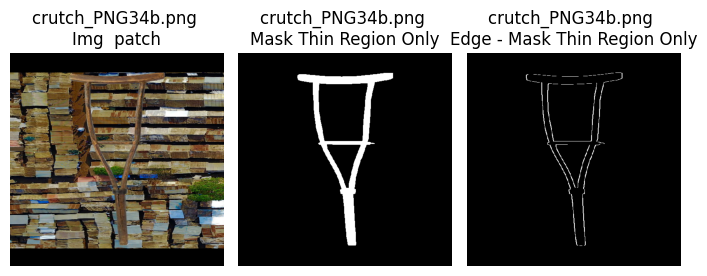

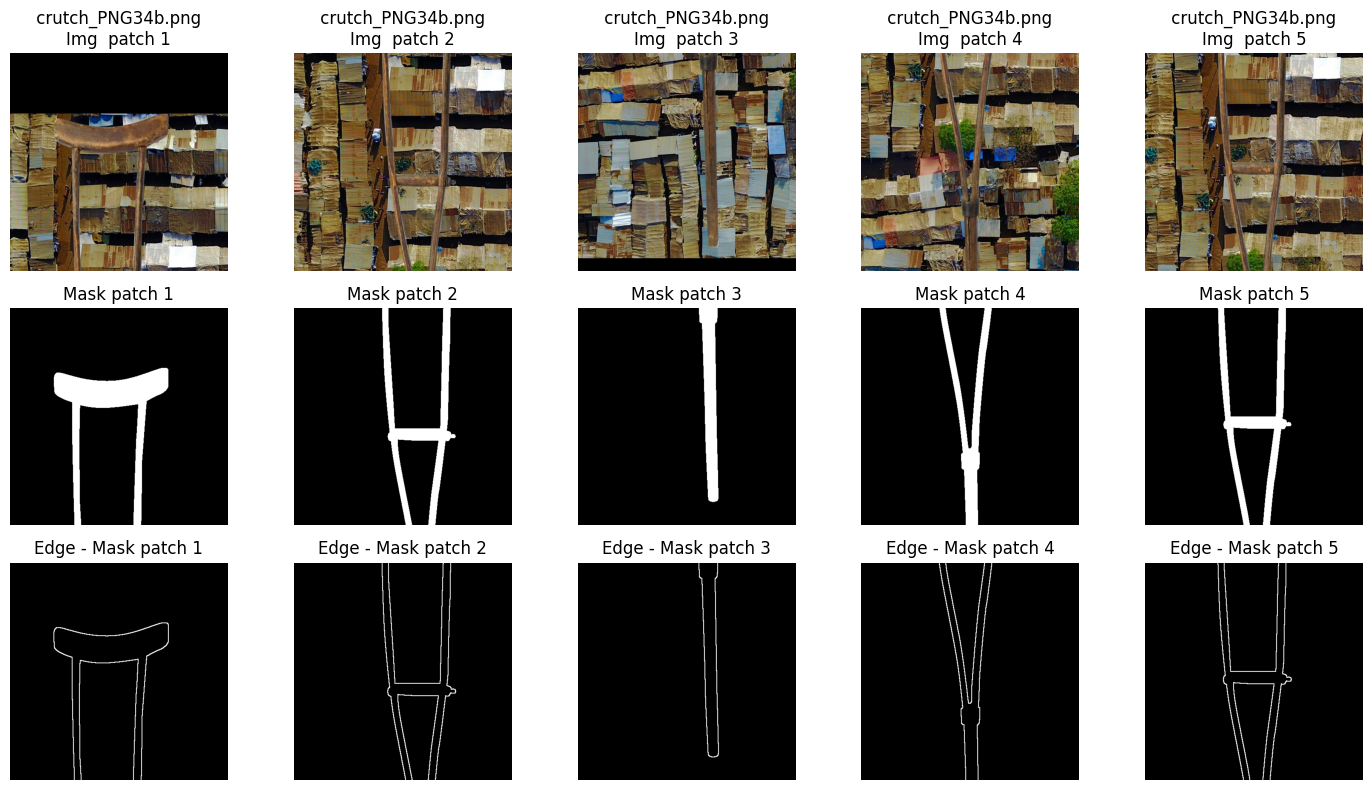

In [23]:
# Extract a sample from the trainloader
sample, inputs, inputs_lr, gts, gts_lr, gt_edge_lr,  gts_edge, meta = extract_transformed_sample(trainloader, device='cuda')

# Visualize the sample
visualize_image_mask(inputs_lr, gts_lr, gt_edge_lr, meta)
visualize_patchs(inputs, gts, gts_edge, meta)